## AP sprint to use analysis_tools to try to make a plot, Sep 2022

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from typing import Mapping, cast

from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

In [28]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config, ConfigDictField, Field
#from lsst.pex.config.listfield import ListField

import lsst.analysis.tools  # my own recent build of main, not the weekly
from lsst.analysis.tools.interfaces import AnalysisPlot
from lsst.analysis.tools.actions.vector import RangeSelector, LoadVector
from lsst.analysis.tools.interfaces import PlotAction, KeyedDataSchema, Vector, KeyedData

In [4]:
#repo = '/sdf/group/rubin/repo/main_20220411'
#repo = '/fs/ddn/sdf/group/rubin/sandbox/bechtol/rc2_subset/SMALL_HSC' # collections='u/bechtol/step3'
#repo = '/sdf/group/rubin/u/ebellm/workspace/cosmos/repo'
#repo = '/sdf/group/rubin/u/ebellm/workspace/hits/repo'
repo = '/sdf/group/rubin/repo/main'
collections = 'u/mrawls/DM-34710/hits2015-fakes'
butler = dafButler.Butler(repo, collections=collections)

In [5]:
registry = butler.registry

## This is the part where I explore what is in the collection

In [65]:
# for d in sorted(registry.queryDatasetTypes()): print(d.name)

In [62]:
# sorted(registry.queryDatasets('fakes_goodSeeingDiff_diaSrcTable'))

In [63]:
# sorted(registry.queryDatasets('fakes_goodSeeingDiff_assocDiaSrc'))

In [64]:
# sorted(registry.queryDatasets('visitSummary'))  # womp womp, only 2014 (template) visits here

In [10]:
oneDiaSrcTable = butler.get('fakes_goodSeeingDiff_diaSrcTable', band='g', instrument='DECam', visit=410929, detector=12)

In [11]:
oneDiaSrcTable.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'flags', 'ra', 'decl',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux',
       'psFluxErr', 'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl',
       'trailLength', 'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr',
       'dipFluxDiff', 'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2',
       'isDipole', 'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF'],
      dtype='object')

In [12]:
oneAssocDiaSrc = butler.get('fakes_goodSeeingDiff_assocDiaSrc', band='g', instrument='DECam', visit=410929, detector=12)

In [13]:
oneAssocDiaSrc.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'flags', 'ra', 'decl',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux',
       'psFluxErr', 'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl',
       'trailLength', 'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr',
       'dipFluxDiff', 'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2',
       'isDipole', 'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF'],
      dtype='object')

In [14]:
oneDiaSrcTable

,diaSourceId,ccdVisitId,filterName,diaObjectId,ssObjectId,parentDiaSourceId,midPointTai,bboxSize,flags,ra,...,dipChi2,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF
0,88246356568703504,41092912,g,0,0,0,57070.160574,16,25299404,155.593509,...,NaN,False,222.647845,155.162712,NaN,NaN,NaN,0.191649,-0.038103,-0.038103
1,88246356568703505,41092912,g,0,0,0,57070.160574,177,25168364,155.599635,...,423304.242655,True,46.513889,253.396348,NaN,NaN,NaN,0.191576,-0.038089,-0.038089
2,88246356568703506,41092912,g,0,0,0,57070.160574,28,25168332,155.594014,...,NaN,False,-117.811564,137.271430,NaN,NaN,NaN,0.191657,-0.038105,-0.038105
3,88246356568703507,41092912,g,0,0,0,57070.160574,49,25168268,155.595341,...,NaN,False,-34.643240,139.200612,NaN,NaN,NaN,0.191590,-0.038092,-0.038092
4,88246356568703508,41092912,g,0,0,0,57070.160574,17,25168332,155.596790,...,NaN,False,-1046.462391,131.916149,NaN,NaN,NaN,0.191659,-0.038105,-0.038105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,88246356568703925,41092912,g,0,0,0,57070.160574,26,25165824,155.887502,...,52.844639,True,30281.108013,234.589412,NaN,NaN,NaN,0.191456,-0.038065,-0.038065
422,88246356568703926,41092912,g,0,0,0,57070.160574,24,25165952,155.887616,...,NaN,False,-463.973988,143.881685,NaN,NaN,NaN,0.191289,-0.038032,-0.038032
423,88246356568703927,41092912,g,0,0,0,57070.160574,25,460,155.887922,...,NaN,False,32261.396811,265.248287,0.191928,0.218104,-0.039303,0.191260,-0.038026,-0.038026
424,88246356568703928,41092912,g,0,0,0,57070.160574,25,2176,155.889785,...,NaN,False,16144.190921,144.685647,0.198787,0.216736,-0.044758,0.191297,-0.038033,-0.038033


In [15]:
oneAssocDiaSrc

,,,diaSourceId,ccdVisitId,filterName,diaObjectId,ssObjectId,parentDiaSourceId,midPointTai,bboxSize,flags,ra,...,dipChi2,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF
diaObjectId,filterName,diaSourceId,,,,,,,,,,,,,,,,,,,,,
88448864276709834,g,88246356568703505,88246356568703505,41092912,g,88448864276709834,0,0,57070.160574,177,25168364,155.599635,...,423304.242655,True,46.513889,253.396348,NaN,NaN,NaN,0.191576,-0.038089,-0.038089
88830472120959334,g,88246356568703507,88246356568703507,41092912,g,88830472120959334,0,0,57070.160574,49,25168268,155.595341,...,NaN,False,-34.643240,139.200612,NaN,NaN,NaN,0.191590,-0.038092,-0.038092
88438126858469848,g,88246356568703508,88246356568703508,41092912,g,88438126858469848,0,0,57070.160574,17,25168332,155.596790,...,NaN,False,-1046.462391,131.916149,NaN,NaN,NaN,0.191659,-0.038105,-0.038105
90538795362943448,g,88246356568703510,88246356568703510,41092912,g,90538795362943448,0,0,57070.160574,17,2176,155.597991,...,NaN,False,948.298655,140.146153,0.192564,0.131817,-0.127132,0.191592,-0.038092,-0.038092
88448864276709837,g,88246356568703511,88246356568703511,41092912,g,88448864276709837,0,0,57070.160574,22,25166092,155.601010,...,47.781734,True,37781.340157,276.891328,NaN,NaN,NaN,0.191550,-0.038084,-0.038084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88246356568703911,g,88246356568703911,88246356568703911,41092912,g,88246356568703911,0,0,57070.160574,13,25165824,155.878373,...,NaN,False,-645.292926,141.960972,NaN,NaN,NaN,0.191290,-0.038032,-0.038032
88246356568703912,g,88246356568703912,88246356568703912,41092912,g,88246356568703912,0,0,57070.160574,15,25166284,155.878830,...,NaN,False,-873.067355,138.161428,NaN,NaN,NaN,0.191245,-0.038023,-0.038023
88246356568703915,g,88246356568703915,88246356568703915,41092912,g,88246356568703915,0,0,57070.160574,20,40,155.882761,...,NaN,False,6638.273674,189.820494,0.038402,0.043637,0.004889,0.191261,-0.038026,-0.038026


## Make a plot of DiaSources on the sky

This is one of the plots I regularly make from the APDB, so I had to figure out how to make it using the available Butler data products instead.

Ideally, the plot will be of DiaObjects on the sky instead, but we don't have a persisted parquet table of DiaObjects yet, so I'm going to do a "proof of concept" with DiaSources.

I envision a generic "DIA Plotter" that assumes a single panel plotting everything on the sky, and specialized plotters that allow for things like more than one panel (a la the HiTS dataset), coloring or sizing points differently depending on flags or nDiaSources or whether they're fakes, etc.

But let's start simple with a typical DECam HiTS style two-panel plot.

In [16]:
# Get all valid visit numbers
visits = sorted(set(dataset.dataId['visit'] for dataset in \
          registry.queryDatasets('fakes_goodSeeingDiff_diaSrcTable')))

In [17]:
# Get all valid detectors for DECam
detectors = np.arange(1, 63)
detectors = detectors[(detectors != 2) & (detectors != 61)]

<IPython.core.display.Javascript object>


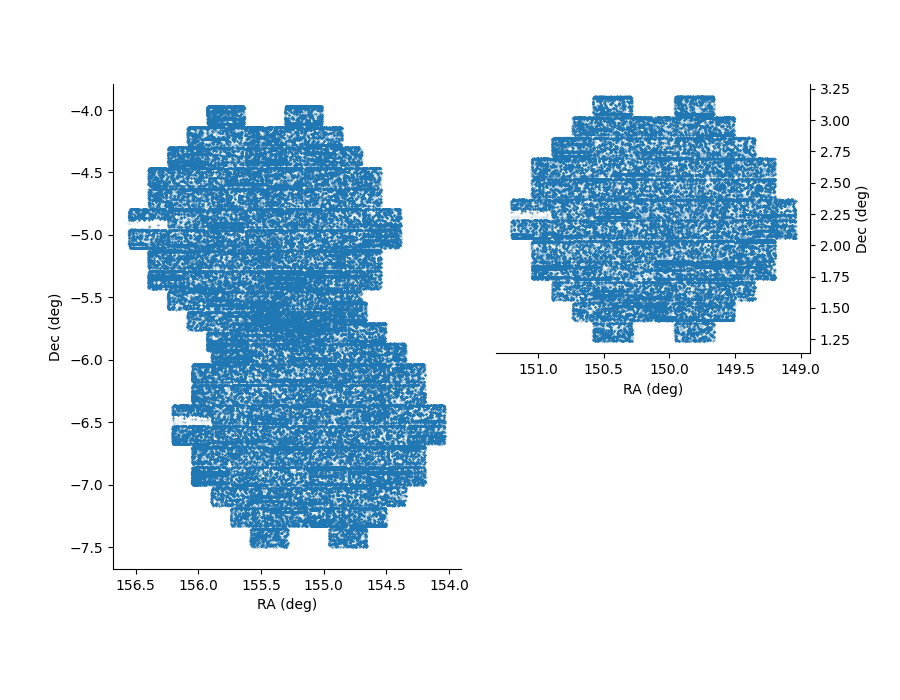

In [18]:
plt.figure(figsize=(9,7))

# Load all DiaSource coordinates from the diaSrcTable
raList = []
decList = []
for visit in visits:
    for detector in detectors:
        ra = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).ra
        dec = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).decl
        raList.append(ra)
        decList.append(dec)
ras = pd.concat(raList)
decs = pd.concat(decList)
df = pd.DataFrame({'ra': ras, 'dec': decs})

# Make the plot
ax1Filter = (df['dec'] > -2)
ax2Filter = (~ax1Filter)

ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)  # right, 1 HiTS field
ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)  # left, 2 HiTS fields

ax1.scatter(df.loc[ax1Filter, 'ra'], df.loc[ax1Filter, 'dec'],
            c='C0', s=0.1, alpha=0.2)
ax2.scatter(df.loc[ax2Filter, 'ra'], df.loc[ax2Filter, 'dec'],
            c='C0', s=0.1, alpha=0.2)

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.invert_xaxis()
ax2.invert_xaxis()
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.subplots_adjust(wspace=0.1, hspace=0)

## Now that we have the plot we want, let's analysis_tools-ify it

In [86]:
class DiaSkyPanel(Config):
    """Configuration options for panels in the subsequent DiaSkyPlot.
    """
    xlabel = Field[str](
        doc="Panel x-axis label.",
        default="RA (deg)",
    )
    ylabel = Field[str](
        doc="Panel y-axis label.",
        default="Dec (deg)",
    )
    invertXAxis = Field[bool](
        doc="Invert x-axis?",
        default=True,
    )
    # Eventually we might retrieve data from more columns to make the plot prettier/more information rich
    ra = Field[str](
        doc="Name of RA column",
        optional=False,
    )
    dec = Field[str](
        doc="Name of Dec column",
        optional=False,
    )
    
class DiaSkyPlot(PlotAction):
    """Generic pseudo base class for plotting DiaSources (or DiaObjects, eventually) on the sky.
    
    The goal is to have a one (or more!) panel plot with RA and Dec points. By default, one panel.
    If more than one panel, some way to filter the RA/Dec coords to decide which ones go to which panel.
    Eventually, knobs you can turn to plot one visit at a time, size DiaObject points by nDiaSources, etc.
    """
    panels = ConfigDictField(
        doc="A configurable dict describing the panels to be plotted, and the data for each panel.",
        keytype=str,
        itemtype=DiaSkyPanel,
        default={},
    )
    
    def getInputSchema(self) -> KeyedDataSchema:
        """Defines the schema this plot action expects (the keys it looks for and what type they should be).
        In other words, verifies that the input data has the columns we are expecting with the right dtypes.
        """
        for panel in self.panels.values():
            yield (panel.ra, Vector)
            yield (panel.dec, Vector)

    def __call__(self, data: KeyedData, **kwargs) -> Mapping[str, Figure] | Figure:
        return self.makePlot(data, **kwargs)

    def makePlot(self, data: KeyedData, plotInfo: Mapping[str, str] = None, **kwargs) -> Figure:
        """Make an N-panel plot with locations of DiaSources or DiaObjects displayed in each panel.
        
        No fancy things for now, just a plot with N panels, each with its own RAs and Decs.
        
        Parameters
        ----------
        data : `lsst.analysis.tools.interfaces.KeyedData` something
        plotInfo : `Mapping` also something
        
        Returns
        -------
        fig : `matplotlib.figure.Figure`
        """
        fig = plt.figure(figsize=(8,6))  # TODO: un-hardwire figsize, probably
        axs = self._makeAxes(fig)
        for panel, ax in zip(self.panels.values(), axs):
            self._makePanel(data, panel, ax, 'C0', **kwargs)
            # fancy colors later; no stats or returns for now
            #handles, labels = ax.get_legend_handles_labels()  # matplotlib legend things; later
            #all_handles += handles
        plt.draw()  # is this needed? do I care?
        return fig

    def _makeAxes(self, fig):
        """Determine axes layout for main figure.
        
        Parameters
        ----------
        fig : `matplotlib.figure.Figure`
        
        Returns
        -------
        axs : `list` containing one or more matplotlib axes, one for each panel
        """
        num_panels = len(self.panels)
        if num_panels <= 1:
            ncols = 1
        else:
            ncols = 2
        nrows = int(np.ceil(num_panels / ncols))
        # TODO: un-hardwire panel dimensions
        gs = GridSpec(nrows, ncols, left=0.13, right=0.99, bottom=0.1, top=0.88, wspace=0.25, hspace=0.45)
        axs = []
        counter = 0
        for row in range(nrows):
            for col in range(ncols):
                counter += 1
                if counter < num_panels:
                    axs.append(fig.add_subplot(gs[row : row + 1, col : col + 1]))
                else:
                    axs.append(fig.add_subplot(gs[row : row + 1, col : np.min([col + 2, ncols + 1])]))
                    break
        return axs
    
    def _makePanel(self, data, panel, ax, color, **kwargs):
        """Plot a single panel.
        
        Parameters
        ----------
        data : `lsst.analysis.tools.interfaces.KeyedData`
        ax : matplotlib axis
        color : `str`
        """       
        ras = cast(Vector, data[panel.ra])
        decs = cast(Vector, data[panel.dec])

        ax.scatter(ras, decs, c=color, s=0.1, alpha=0.2)  # un-hardwire plot parameters (via i index?) later
        # ax.legend()  # later
        ax.set_xlabel(panel.xlabel)
        ax.set_ylabel(panel.ylabel)
        if panel.invertXAxis:
            ax.invert_xaxis()
        

In [84]:
#from lsst.analysis.tools.actions.plot.diaSkyPlot import DiaSkyPlot, DiaSkyPanel  # these don't exist yet

class HitsDiaPlot(AnalysisPlot):
    """Specialized plotter that calls the more generic DiaSkyPlot for plotting RA/Dec of DiaSources.
    
    It makes two panels that make the HiTS fields look pretty.
    Don't put ANY PLOTTING CODE HERE. Just configs and produce and labels and stuff.
    
    Need to have ALL OF: prep, process, and produce steps
    """
    def setDefaults(self):
        super().setDefaults()
      
        # Ra1, Dec1 are for panel1; Ra2, Dec2 are for panel2        
        
        # define the dec range for each panel
        #self.prep.selectors.rangeselector1 = RangeSelector()
        #self.prep.selectors.rangeselector1.column = 'dec'
        #self.prep.selectors.rangeselector1.minimum = -2
        
        # add this one later for panel 2
        #self.prep.selectors.rangeselector2 = RangeSelector()
        #self.prep.selectors.rangeselector2.column = 'dec'
        #self.prep.selectors.rangeselector2.maximum = -2
        
        self.process.buildActions.ra1s = LoadVector()  # TODO: try DownSelect to do the selection desired
        self.process.buildActions.ra1s.vectorKey = 'ra'
        self.process.buildActions.dec1s = LoadVector()
        self.process.buildActions.dec1s.vectorKey = 'dec'
        
        self.process.buildActions.ra2s = LoadVector()  # TODO: try DownSelect to do the selection desired
        self.process.buildActions.ra2s.vectorKey = 'ra'
        self.process.buildActions.dec2s = LoadVector()
        self.process.buildActions.dec2s.vectorKey = 'dec'

        self.produce = DiaSkyPlot()

        # TODO: customize panel sizes and locations by sending configs to DiaSkyPlot somehow
        #ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)  # right, 1 HiTS field
        #ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)  # left, 2 HiTS fields
    
        self.produce.panels['panel_right'] = DiaSkyPanel()
        self.produce.panels['panel_right'].xlabel = 'RA (deg)'
        self.produce.panels['panel_right'].ylabel = 'Dec (deg)'
        # these are dicts in case we want more than one thing on the same plot; could pass it "ra" like the labels
        self.produce.panels["panel_right"].ra = 'ra1s'
        self.produce.panels["panel_right"].dec = 'dec1s'
        
        self.produce.panels['panel_left'] = DiaSkyPanel()
        self.produce.panels['panel_left'].xlabel = 'RA (deg)'
        self.produce.panels['panel_left'].ylabel = 'Dec (deg)'
        self.produce.panels['panel_left'].ra = 'ra2s'
        self.produce.panels['panel_left'].dec = 'dec2s'

In [69]:
# If you're running the notebook from top to bottom, `df` is already defined

###
# This bit should land in a runQuantum method for a new pipelineTask to create a metric, which we can then plot
# That way, this code is available for making all kinds of various plots
# Note that analysis_tools has Tasks, Eric wrote one
raList = []
decList = []
for visit in visits:
    for detector in detectors:
        ra = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).ra
        dec = butler.get('fakes_goodSeeingDiff_diaSrcTable', visit=visit, detector=detector).decl
        raList.append(ra)
        decList.append(dec)
ras = pd.concat(raList)
decs = pd.concat(decList)
df = pd.DataFrame({'ra': ras, 'dec': decs})
###


<IPython.core.display.Javascript object>


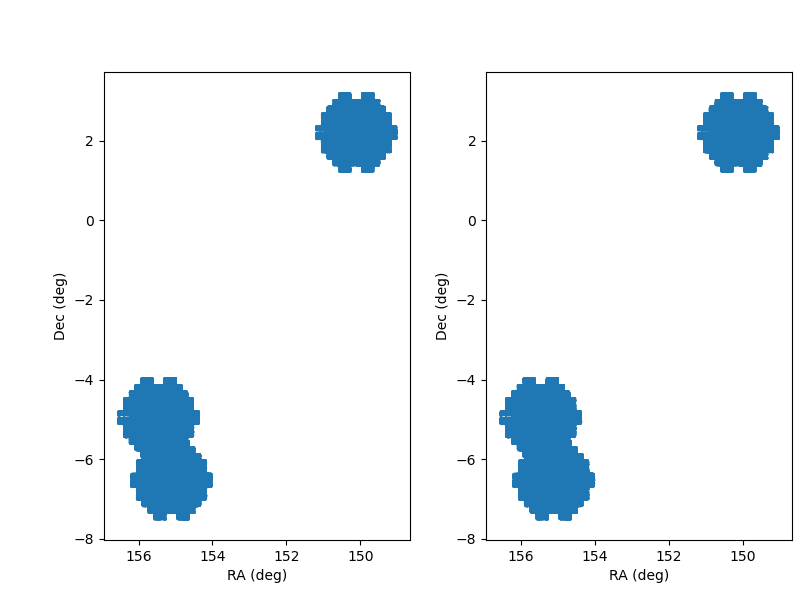

In [87]:
# Call the things we wrote to actually make the plot

plot = HitsDiaPlot()(df)

# Fancy way to do this one step at a time
#plot.populatePrepFromProcess()
#stage1 = plot.prep(df)
#stage1.addInputSchema()
#print(stage1)  # should contain all columns needed for the plot
#stage2 = plot.process(stage1)
#print(stage2)
#stage3 = plot.produce(stage2)
#print(stage3)